# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [25]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [26]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [27]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [28]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Exploratory Analysis and Data Cleaning

In this section we will conduct some exploratory analysis and do some initial data cleaning and format change. Based on the need in later section, will do further manipulation.

## Portfolio Dataset

First step we want to clean up channels column in portfolio. <br/>
ref: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

In [29]:
# check the format in original data
# they are already in list format so we can directly expand them into their own columns
for i, l in enumerate(portfolio.channels):
    print("list",i,"is",type(l))

list 0 is <class 'list'>
list 1 is <class 'list'>
list 2 is <class 'list'>
list 3 is <class 'list'>
list 4 is <class 'list'>
list 5 is <class 'list'>
list 6 is <class 'list'>
list 7 is <class 'list'>
list 8 is <class 'list'>
list 9 is <class 'list'>


In [30]:
def boolean_df(item_lists, unique_items):
    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [31]:
temp_channel = boolean_df(portfolio.channels, ['web', 'email', 'mobile', 'social'])
temp_channel.columns = ['ch_web', 'ch_email', 'ch_mobile', 'ch_social']
temp_channel.head()

,ch_web,ch_email,ch_mobile,ch_social
0,0,1,1,1
1,1,1,1,1
2,1,1,1,0
3,1,1,1,0
4,1,1,0,0


In [83]:
# deal with categorical varibles and create dummy variables

portfolio = pd.concat([portfolio, temp_channel], axis = 1).drop('channels', axis = 1)
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio.offer_type, prefix='type')], axis = 1) \
        .drop('offer_type', axis = 1)
portfolio

,reward,difficulty,duration,id,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_discount,type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


## Profile Dataset

In [33]:
# age looks weird
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


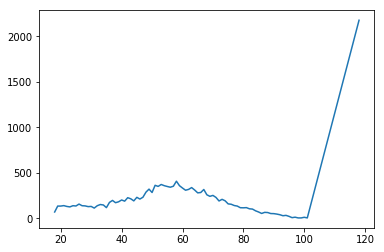

In [12]:
plt.plot(profile.age.value_counts().sort_index())

In [35]:
# exclude ages greater than 80
# notice that occurrances with age = 118 are highly correlated with null values in other columns

profile['age_new'] = profile.age.apply(lambda x: x if x <= 80 else None)
profile.head()

,gender,age,id,became_member_on,income,age_new
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,55.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,75.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,NaN


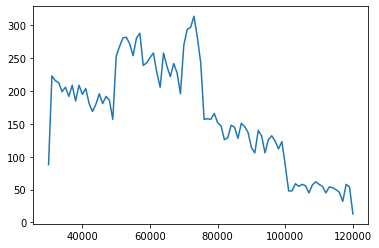

In [36]:
# distribution of income looks good
plt.plot(profile.income.value_counts().sort_index())

In [37]:
# check gender info
profile.gender.value_counts(dropna = False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

## Transcript Dataset

In [38]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [39]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [16]:
transcript[transcript.event == 'offer received'].time.value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

In [40]:
# will need to extract data from value field
transcript.value.head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [41]:
# iterate through the column and find all possible keys

all_keys = set()
for row in range(transcript.shape[0]):
    all_keys = all_keys.union(transcript.value.iloc[row].keys())
all_keys

{'amount', 'offer id', 'offer_id', 'reward'}

In [42]:
# create function to extract value by key

def get_dict_val(orig_val, key):
    try:
        res = orig_val[key]
    except:
        res = None
    return res

In [43]:
transcript['offer id'] = transcript.value.apply(lambda x: get_dict_val(x, 'offer id'))
transcript['offer_id'] = transcript.value.apply(lambda x: get_dict_val(x, 'offer_id'))
transcript['reward'] = transcript.value.apply(lambda x: get_dict_val(x, 'reward'))
transcript['amount'] = transcript.value.apply(lambda x: get_dict_val(x, 'amount'))

In [45]:
# check if there are rows with both offer id and offer_id
# if not then we can combine the 2 columns

transcript[(~transcript['offer id'].isnull()) & (~transcript['offer_id'].isnull())]

,person,event,value,time,offer id,offer_id,reward,amount


In [46]:
transcript['offer_id'] = transcript['offer id'].fillna('').astype('str') + transcript['offer_id'].fillna('').astype('str')

In [47]:
transcript.drop('offer id', axis = 1, inplace=True)

In [48]:
transcript.head()

,person,event,value,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


### Some draft

In [49]:
# user_offer_pair_complete = transcript.loc[transcript.event == 'offer completed', ['person', 'offer_id']].drop_duplicates()
# print('has ', user_offer_pair_complete.shape[0], ' rows')

In [50]:
# user_offer_pair_complete['indicator'] = 1

In [39]:
# user_offer_pair_view = transcript.loc[transcript.event == 'offer viewed', ['person', 'offer_id']].drop_duplicates()
# print('has ', user_offer_pair_view.shape[0], ' rows')

In [51]:
# user_offer_pair_receive = transcript.loc[transcript.event == 'offer received', ['person', 'offer_id']].drop_duplicates()
# print('has ', user_offer_pair_receive.shape[0], ' rows')

In [52]:
# pd.merge(user_offer_pair_complete, user_offer_pair_complete, how = 'left')['indicator'].sum()

# Predict whether they will view it

In [ ]:
# <!-- Since we do not have data of the users who are not part of this promotion experiment, we won't be able to compare whether these offers actually brings more revenue.  -->

For users to be affected by the promotions, the first step is for them to view the offer once sent. we can compare what demographic groups have a higher possibility to view the offer.

Assuming the possibility of an offer being viewed is irrelavant of what type of offer it is, or other similar information

## Data Cleaning

### Portfolio

Assuming the possibility of an offer being viewed is irrelavant of what type of offer it is, or other similar information

In [84]:
portfolio

,reward,difficulty,duration,id,ch_web,ch_email,ch_mobile,ch_social,type_bogo,type_discount,type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


In [85]:
# drop some column because if won't affect user behavior until the offer is viewed
portfolio_copy = portfolio.drop(['difficulty', 'duration','reward', 'type_bogo', 'type_discount', 'type_informational'], axis = 1).copy()

In [86]:
portfolio_copy

,id,ch_web,ch_email,ch_mobile,ch_social
0,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


### Transcript

In [54]:
transcript_received = transcript[transcript.event == 'offer received'].copy()
transcript_viewed = transcript[transcript.event == 'offer viewed'].copy()

Double check if there are viewed records with no received records.

In [55]:
# Double check that there are no viewed records with no received records
transcript_viewed[~transcript_viewed.person.isin(transcript_received.person.unique())]

,person,event,value,time,offer_id,reward,amount


Check if there are duplicates, i.e. same offer sent to same person multiple times, and have multiple views. We can't identify which one they saw, but since we only need to know whether they are viewed or not, we can just drop duplicates and not use the time

In [56]:
transcript_received[transcript_received.duplicated(subset = ['event','person', 'offer_id'], keep = False)].sort_values(['person', 'offer_id'])

,person,event,value,time,offer_id,reward,amount
56475,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
248359,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
1889,0020c2b971eb4e9188eac86d93036a77,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
112698,0020c2b971eb4e9188eac86d93036a77,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
55857,003d66b6608740288d6cc97a6903f4f0,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},168,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
...,...,...,...,...,...,...,...
184,fffad4f4828548d1b5583907f2e9906b,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
150794,fffad4f4828548d1b5583907f2e9906b,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
112214,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},336,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
152030,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408,2906b810c7d4411798c6938adc9daaa5,NaN,NaN


In [57]:
transcript_received.drop_duplicates(subset=['person', 'offer_id'], inplace = True)

In [58]:
transcript_viewed.drop_duplicates(subset=['person', 'offer_id'], inplace = True)

In [66]:
# combine the data with only important fields

df_viewed = pd.merge(transcript_received.drop(['event', 'value', 'reward', 'amount'], axis=1), 
         transcript_viewed.drop(['event', 'value', 'reward', 'amount'], axis = 1), 
         how = 'left',
         left_on = ['person', 'offer_id'], 
         right_on = ['person', 'offer_id'], 
         suffixes=('_recv', '_view'))

In [68]:
df_viewed['is_viewed'] = np.where(df_viewed.time_view.isnull(),0,1)
df_viewed = df_viewed.drop(['time_recv', 'time_view'], axis = 1)
df_viewed.head()

,person,offer_id,is_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,1
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,1


### Profile

In [71]:
profile.head()

,gender,age,id,became_member_on,income,age_new
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,55.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,75.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,NaN


In [72]:
profile_copy = profile.dropna().copy()

In [73]:
# create bins for tenure based on membership date
# though its a ordinal value field, we'll treat it as regular categorical field

tenure_bins = np.array([20130101, 20151231, 20161231, 20171231, 20181231])
profile_copy['tenure_bins'] = pd.cut(profile_copy.became_member_on, tenure_bins, labels = ['join_13_15', 'join_16', 'join_17', 'join_18'])

In [74]:
profile_copy.head()

,gender,age,id,became_member_on,income,age_new,tenure_bins
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,55.0,join_17
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,75.0,join_17
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,68.0,join_18
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,65.0,join_18
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,58.0,join_17


In [75]:
profile_copy.tenure_bins.value_counts()

join_17       5235
join_18       3452
join_16       2770
join_13_15    2382
Name: tenure_bins, dtype: int64

In [76]:
# handle categorical values

profile_copy = pd.concat([profile_copy, pd.get_dummies(profile_copy.gender, prefix='gen')], axis = 1).drop(['age', 'became_member_on', 'gender', 'gen_M'], axis = 1)
profile_copy = pd.concat([profile_copy, pd.get_dummies(profile_copy.tenure_bins, prefix='ten')], axis = 1).drop(['tenure_bins', 'ten_join_18'], axis = 1)

In [77]:
profile_copy.head()

,id,income,age_new,gen_F,gen_O,ten_join_13_15,ten_join_16,ten_join_17
1,0610b486422d4921ae7d2bf64640c50b,112000.0,55.0,1,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,75.0,1,0,0,0,1
5,e2127556f4f64592b11af22de27a7932,70000.0,68.0,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,65.0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,58.0,0,0,0,0,1


### Combine Data

In [104]:
dataset = pd.merge(pd.merge(df_viewed, portfolio_copy, left_on = 'offer_id', right_on = 'id').drop(['offer_id', 'id'], axis = 1)
         , profile_copy
         , left_on = 'person'
         , right_on = 'id').drop(['person', 'id'], axis = 1)

In [106]:
dataset.head()

,is_viewed,ch_web,ch_email,ch_mobile,ch_social,income,age_new,gen_F,gen_O,ten_join_13_15,ten_join_16,ten_join_17
0,1,1,1,1,0,100000.0,75.0,1,0,0,0,1
1,1,1,1,1,1,100000.0,75.0,1,0,0,0,1
2,1,0,1,1,1,100000.0,75.0,1,0,0,0,1
3,1,0,1,1,1,100000.0,75.0,1,0,0,0,1
4,1,1,1,1,0,41000.0,59.0,0,0,1,0,0


## Logistic Regression

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [107]:
# all promotions were sent through email, need to drop email column
dataset.drop('ch_email', axis = 1, inplace = True)

ref: below uses sample codes from https://www.udemy.com/course/machinelearning/

In [108]:
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

In [109]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Feature Scaling

In [110]:
# not necessary for logic regression but helpful to plot, and interpreting coeficients
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [111]:
# model fit
classifier = LogisticRegression(random_state = 200)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=200)

In [112]:
# prediction
y_pred = classifier.predict(X_test)

In [113]:
# confusion matrix and accuracy
recall_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1212 1810]
 [ 625 9244]]


0.811108525327748

In [115]:
# other metrics
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))

precision:  0.8362583680115795
recall:  0.9366703820042558
f1_score:  0.8836208956650576


Feature: 0, Score: 0.46261
Feature: 1, Score: 0.23771
Feature: 2, Score: 1.56734
Feature: 3, Score: 0.11628
Feature: 4, Score: 0.07782
Feature: 5, Score: 0.02401
Feature: 6, Score: 0.09053
Feature: 7, Score: 0.04426
Feature: 8, Score: 0.06077
Feature: 9, Score: 0.02473


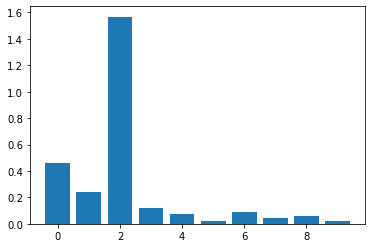

In [116]:
# https://pythonguides.com/scikit-learn-logistic-regression/

importance = classifier.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [117]:
# for better feature selection, we need other metrics like p-value in statsmodels, which is not available in sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = sm.Logit(y_test, sm.add_constant(X_test))
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.393349
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.278     
Dependent Variable: y                AIC:              10163.3310
Date:               2022-02-13 21:32 BIC:              10245.4381
No. Observations:   12891            Log-Likelihood:   -5070.7   
Df Model:           10               LL-Null:          -7020.1   
Df Residuals:       12880            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
-------------------------------------------------------------------
const       1.8051     0.0362   49.8213   0.0000    1.7341   1.8761
x1          0.5152     0.0408   12.6238   0.0000    0.4352   0.5952
x2          0.2649     0.0198   13.3710   0.0000    0.2261   0.3037
x3          1.5614     0.0423   36.9461   0.0000    1.4786   1.6443
x4          0.1131     0.0271    4.1701   0.0000    0.0599   0.1662
x5          0.0781     0.0258    3.0289   0.0025    0.0276   0.1286
x6          0.0526     0.0258    2.0408   0.0413    0.0021   0.1032
x7          0.1078     0.0275    3.9261   0.0001    0.0540   0.1617
x8          0.1064     0.0290    3.6653   0.0002    0.0495   0.1632
x9          0.0917     0.0301    3.0473   0.0023    0.0327   0.1507
x10         0.0338     0.0308    1.0965   0.2728   -0.0266   0.0941
=================================================================

"""

## Reduce Dimension

In [119]:
# because it ten_join_17 is not significant
dataset.drop('ten_join_17', axis = 1, inplace = True)
# because it ten_join_13_15, ten_join_16 is not practically significant
dataset.drop(['ten_join_13_15', 'ten_join_16'], axis = 1, inplace = True)
# because not enough practical significance
# ref: https://towardsdatascience.com/a-simple-interpretation-of-logistic-regression-coefficients-e3a40a62e8cf
dataset.drop(['gen_F'], axis = 1, inplace = True)

In [120]:
dataset.head()

,is_viewed,ch_web,ch_mobile,ch_social,income,age_new,gen_O
0,1,1,1,0,100000.0,75.0,0
1,1,1,1,1,100000.0,75.0,0
2,1,0,1,1,100000.0,75.0,0
3,1,0,1,1,100000.0,75.0,0
4,1,1,1,0,41000.0,59.0,0


In [121]:
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

In [122]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Feature Scaling

In [123]:
# not necessary for logic regression but helpful to plot, and interpreting coeficients
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [124]:
# model fit
classifier = LogisticRegression(random_state = 200)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=200)

In [125]:
# prediction
y_pred = classifier.predict(X_test)

In [126]:
# confusion matrix and accuracy
recall_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1166 1856]
 [ 644 9225]]


0.8060662477697619

In [127]:
# other metrics
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))

precision:  0.8325060915079866
recall:  0.9347451616171851
f1_score:  0.8806682577565632


Feature: 0, Score: 0.46186
Feature: 1, Score: 0.23713
Feature: 2, Score: 1.56618
Feature: 3, Score: 0.12658
Feature: 4, Score: 0.08041
Feature: 5, Score: 0.08729


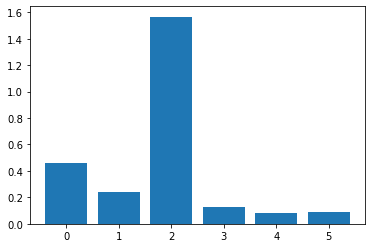

In [128]:
# https://pythonguides.com/scikit-learn-logistic-regression/

importance = classifier.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [129]:
# for better feature selection, we need other metrics like p-value in statsmodels, which is not available in sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = sm.Logit(y_test, sm.add_constant(X_test))
results = model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.394253
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.276     
Dependent Variable: y                AIC:              10178.6326
Date:               2022-02-13 21:37 BIC:              10230.8826
No. Observations:   12891            Log-Likelihood:   -5082.3   
Df Model:           6                LL-Null:          -7020.1   
Df Residuals:       12884            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
--------------------------------------------------------------------
         Coef.     Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const    1.8024      0.0362    49.8112    0.0000    1.7315    1.8733
x1       0.5158      0.0408    12.6449    0.0000    0.4359    0.5958
x2       0.2649      0.0198    13.3948    0.0000    0.2262    0.3037
x3       1.5586      0.0422    36.9101    0.0000    1.4758    1.6413
x4       0.1334      0.0264     5.0465    0.0000    0.0816    0.1852
x5       0.0800      0.0257     3.1137    0.0018    0.0297    0.1304
x6       0.1007      0.0273     3.6856    0.0002    0.0471    0.1542
=================================================================

"""

# Predict if they viewed it, how likely they will complete it

First need to exclude offer completed without viewing it, or before it's viewed

In [239]:
transcript.head()

,event,person,time,value,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [247]:
df_first_viewed = transcript[transcript.event == 'offer viewed'].groupby(['person', 'offer_id'])['time'].min().reset_index()

In [264]:
df_first_viewed.head()

,person,offer_id,time
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,216


In [274]:
df_completed = transcript[transcript.event == 'offer completed'].copy()

In [275]:
df_completed[df_completed.duplicated(['person', 'offer_id'], keep = False)].sort_values('person')

,event,person,time,value,offer_id,reward,amount
31327,offer completed,0020c2b971eb4e9188eac86d93036a77,54,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
218936,offer completed,0020c2b971eb4e9188eac86d93036a77,510,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
144668,offer completed,003d66b6608740288d6cc97a6903f4f0,384,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
216735,offer completed,003d66b6608740288d6cc97a6903f4f0,504,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
239694,offer completed,004c5799adbf42868b9cff0396190900,558,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN
87420,offer completed,004c5799adbf42868b9cff0396190900,222,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
258607,offer completed,004c5799adbf42868b9cff0396190900,576,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN
177710,offer completed,004c5799adbf42868b9cff0396190900,432,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN
295666,offer completed,00715b6e55c3431cb56ff7307eb19675,666,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,NaN
84520,offer completed,00715b6e55c3431cb56ff7307eb19675,210,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,NaN


In [276]:
df_completed[df_completed.duplicated(['person', 'offer_id', 'time'], keep = False)]

,event,person,time,value,offer_id,reward,amount
66122,offer completed,3dde94fa581145cb9f206624f1a94d5a,168,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN
66123,offer completed,3dde94fa581145cb9f206624f1a94d5a,168,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN
66782,offer completed,e9fb6ed2cecb4980ba98c86abc9c91e3,168,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN
66783,offer completed,e9fb6ed2cecb4980ba98c86abc9c91e3,168,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN
67613,offer completed,a7dc060f6fc94ca7bf71fbb188187dca,168,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
67614,offer completed,a7dc060f6fc94ca7bf71fbb188187dca,168,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN
68561,offer completed,30478a4c1e884a63a822aa87b833ed7a,168,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,NaN
68562,offer completed,30478a4c1e884a63a822aa87b833ed7a,168,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,NaN
69217,offer completed,84fb57a7fe8045a8bf6236738ee73a0f,168,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN
69218,offer completed,84fb57a7fe8045a8bf6236738ee73a0f,168,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN


In [277]:
df_completed.drop_duplicates(['person', 'offer_id', 'time'], inplace = True)

In [298]:
df_comp_view = pd.merge(df_completed, df_first_viewed, 
                        how = 'left',
                        left_on=['person', 'offer_id'], right_on=['person', 'offer_id'])

In [299]:
df_comp_view.shape

(33182, 8)

In [300]:
df_comp_view.head()

,event,person,time_x,value,offer_id,reward,amount,time_y
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,0.0
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,6.0
2,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,0.0
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN,0.0
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,0.0


In [301]:
df_comp_view = df_comp_view.loc[~((df_comp_view.time_y.isnull()) | (df_comp_view.time_x < df_comp_view.time_y))]

In [303]:
df_comp_view

,event,person,time_x,value,offer_id,reward,amount,time_y
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,0.0
2,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,0.0
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,10.0,NaN,0.0
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,0.0
5,offer completed,227f2d69e46a4899b70d48182822cff6,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,0.0
7,offer completed,d72d201be5794279aa716d8ad82b8d90,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,0.0
8,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,2.0,NaN,0.0
9,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,NaN,0.0
16,offer completed,c3321bc76743445c9103eef0ce9d833b,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,NaN,0.0
19,offer completed,5152fa6375184287b06e2fd0d5abed34,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,0.0


In [307]:
df_comp_view[df_comp_view.duplicated(['person', 'offer_id'], keep = False)].sort_values('person')

,event,person,time_x,value,offer_id,reward,amount,time_y
21010,offer completed,0020c2b971eb4e9188eac86d93036a77,510,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,12.0
2304,offer completed,0020c2b971eb4e9188eac86d93036a77,54,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,12.0
20682,offer completed,003d66b6608740288d6cc97a6903f4f0,504,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,300.0
13137,offer completed,003d66b6608740288d6cc97a6903f4f0,384,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,300.0
16317,offer completed,004c5799adbf42868b9cff0396190900,432,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,408.0
25641,offer completed,004c5799adbf42868b9cff0396190900,576,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,174.0
7689,offer completed,004c5799adbf42868b9cff0396190900,222,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,2.0,NaN,174.0
24652,offer completed,004c5799adbf42868b9cff0396190900,558,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,408.0
12075,offer completed,0082fd87c18f45f2be70dbcbb0fb8aad,366,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,348.0
17695,offer completed,0082fd87c18f45f2be70dbcbb0fb8aad,450,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,348.0


In [309]:
df_comp_view.drop_duplicates(['person', 'offer_id'], inplace = True)

In [317]:
df_comp_view = df_comp_view[['person', 'offer_id']].copy()

In [318]:
df_comp_view.duplicated().sum()

0

In [319]:
df_comp_view.head()

,person,offer_id
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5
2,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0
5,227f2d69e46a4899b70d48182822cff6,4d5c57ea9a6940dd891ad53e9dbe8da0


In [320]:
df_comp_view['is_completed'] = 1

In [321]:
df_comp_view.head()

,person,offer_id,is_completed
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,1
2,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,1
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,1
5,227f2d69e46a4899b70d48182822cff6,4d5c57ea9a6940dd891ad53e9dbe8da0,1


In [325]:
df_viewed = pd.merge(df_first_viewed, df_comp_view, 
         how = 'left',
         left_on=['person', 'offer_id'], right_on = ['person', 'offer_id'])

In [328]:
df_viewed['is_completed'] = df_viewed.is_completed.fillna(0)

In [329]:
df_viewed.head()

,person,offer_id,time,is_completed
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,0.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,0.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,0.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,0.0
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,216,0.0


In [330]:
df_viewed.is_completed.value_counts()

0.0    27763
1.0    21372
Name: is_completed, dtype: int64